In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Probability of sharing distribution

We use the US 2016 elections dataset in "*Balancing Information Exposure in Social Networks*" to study the distribution of sharing probabilities.

In [2]:
# load seeds
A = [l.strip() for l in open("side1_seeds.txt").readlines()]  # A = pro Hillary
B = [l.strip() for l in open("side2_seeds.txt").readlines()]  # B = pro Trump
len(A), len(B)

(85, 99)

In [3]:
# load probabilities
df = pd.read_csv("uselections_network_heterogeneous.txt", sep='\t', names=['User1', 'User2', 'p1', 'p2'])
df

,User1,User2,p1,p2
0,003a04f8c2054b7,birdonachair,0.000834,0.008674
1,003a04f8c2054b7,patriot18d,0.001160,0.003320
2,003a04f8c2054b7,pamela_moore13,0.000143,0.004143
3,003a04f8c2054b7,jbaker31826004,0.000604,0.015884
4,003a04f8c2054b7,glucklichschon,0.001960,0.019880
...,...,...,...,...
845147,healthyyoga07,rickrwells,0.000250,0.010810
845148,healthyyoga07,supercos7,0.004560,0.015920
845149,healthyyoga07,ladiesfortrump,0.001448,0.032888
845150,healthyyoga07,usa_with_trump,0.001067,0.016427


## Heterogenous model

Articles $a$ and $b$ propagate independently of each other: $u_2$ shares article $a$ with probability $p_1$, given that $u_1$ shared it. Analogously, $u_2$ shares article $b$ it with probability $p_2$, given that $u_1$ shared it.

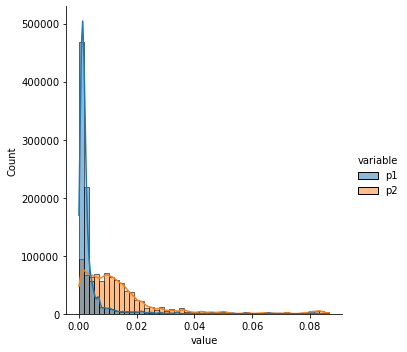

In [4]:
sns.displot(data=pd.melt(df,
                         id_vars=['User1', 'User2'],
                         value_vars=['p1', 'p2']),
            x='value',
            hue='variable',
            bins=50, kde=True)

A beta distribution may fit well.

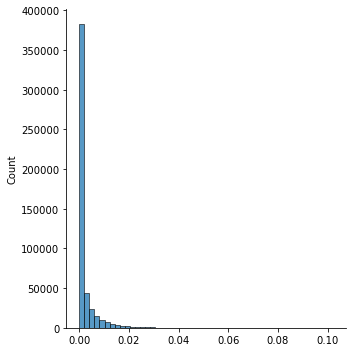

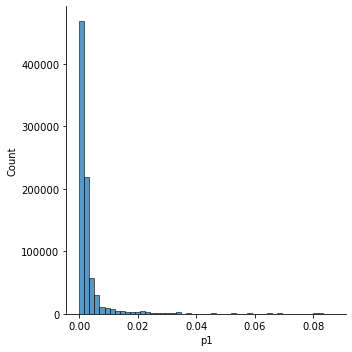

In [5]:
sns.displot(np.random.beta(a=0.2, b=100.0, size=500000), bins=50)
sns.displot(df.p1, bins=50)

The probabilities above are the conditional probabilities on a given initiator. We are implicitly assuming that the probability of sharing is independent of the initiator. This is probably not the case in practice since reputation and credibility are important factors for retweeting.

Let's calculate the average probability of sharing:

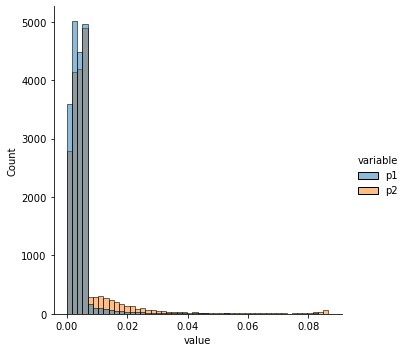

In [6]:
p_share = df.groupby('User2').mean().reset_index()
sns.displot(data=pd.melt(p_share,
                         id_vars=['User2'],
                         value_vars=['p1', 'p2']),
            x='value',
            hue='variable', bins=50)

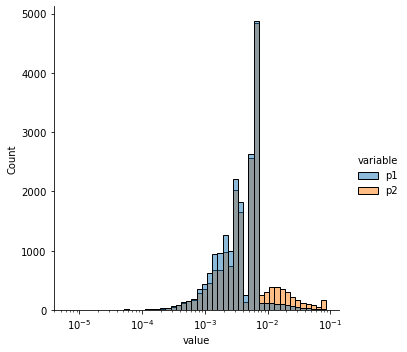

In [7]:
sns.displot(data=pd.melt(p_share,
                         id_vars=['User2'],
                         value_vars=['p1', 'p2']),
            x='value',
            hue='variable', bins=50, log_scale=(True, False))

## Different groups

Ideally, we would like to study the distributions of $p_{A, s}$ and $p_{B, s}$ and not just $p_{*, a}$ and $p_{*,b}$ (i.e., the probabilities of clicking on the articles regardless of group membership).

In [8]:
dfg = df[df.User2.isin(B) | df.User2.isin(A)]

In [9]:
group = df.User2.isin(A).replace({True: 'A', False: 'B'})

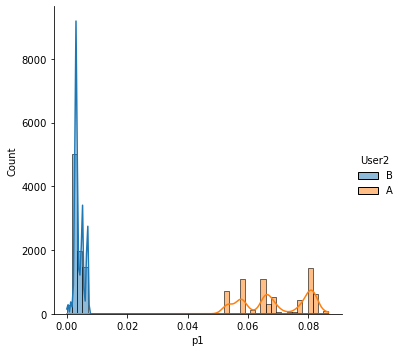

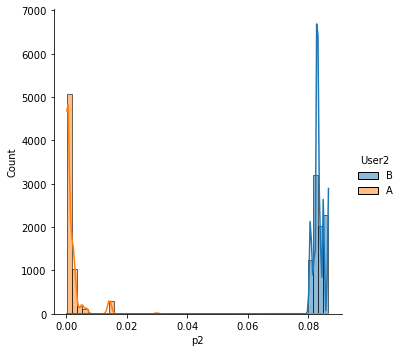

In [10]:
sns.displot(data=dfg, x='p1', hue=group, bins=50, kde=True)
sns.displot(data=dfg, x='p2', hue=group, bins=50, kde=True)

It makes sense because the probability of sharing the article that agrees with your views is higher than otherwise.

There doesn't seem to be enough data to say anything about the shape of the distributions.